In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm.notebook import tqdm
plt.style.use('fivethirtyeight')

The goal of this notebook is to make the final data analysis and the customer segmentation.

## I. Loading and merging the datasets

In [2]:
customer = pd.read_csv("../Datasets/Processed/customer_data_preprocessed.csv")
transaction = pd.read_csv("../Datasets/Processed/transaction_data_preprocessed.csv")
data = customer.merge(transaction, on="LYLTY_CARD_NBR", how="left" )
#TXN_ID is useless
data.drop(columns=["Unnamed: 0_x","Unnamed: 0_y","TXN_ID"], inplace=True)
data.head()

LYLTY_CARD_NBR              LIFESTAGE PREMIUM_CUSTOMER     DATE  STORE_NBR  \
0            1000  YOUNG SINGLES/COUPLES          Premium  43390.0        1.0   
1            1002  YOUNG SINGLES/COUPLES       Mainstream  43359.0        1.0   
2            1003         YOUNG FAMILIES           Budget  43531.0        1.0   
3            1003         YOUNG FAMILIES           Budget  43532.0        1.0   
4            1004  OLDER SINGLES/COUPLES       Mainstream  43406.0        1.0   

   PROD_NBR  PROD_QTY  UNIT_PRICE  
0       5.0       2.0         3.0  
1      58.0       1.0         2.7  
2      52.0       1.0         3.6  
3     106.0       1.0         3.0  
4      96.0       1.0         1.9

In [3]:
data.describe()

LYLTY_CARD_NBR           DATE      STORE_NBR       PROD_NBR  \
count    2.648340e+05  264833.000000  264833.000000  264833.000000   
mean     1.355492e+05   43464.036570     135.079529      56.583598   
std      8.058007e+04     105.389061      76.784189      32.826498   
min      1.000000e+03   43282.000000       1.000000       1.000000   
25%      7.002100e+04   43373.000000      70.000000      28.000000   
50%      1.303575e+05   43464.000000     130.000000      56.000000   
75%      2.030940e+05   43555.000000     203.000000      85.000000   
max      2.373711e+06   43646.000000     272.000000     114.000000   

            PROD_QTY     UNIT_PRICE  
count  264833.000000  264833.000000  
mean        1.905812       3.826375  
std         0.343437       1.110930  
min         1.000000       1.500000  
25%         2.000000       3.000000  
50%         2.000000       3.800000  
75%         2.000000       4.600000  
max         5.000000       6.500000

In [4]:
ProfileReport(data)

## II. Analysis

### 1.Reduce the number of category in products

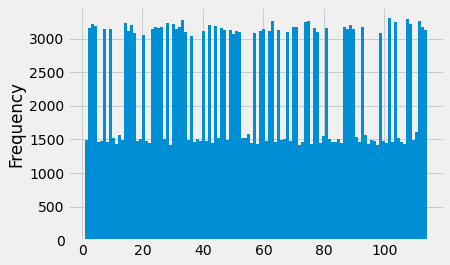

In [5]:
data["PROD_NBR"].plot(kind="hist", bins=114);

#### a. Consumption frequency clustering

<AxesSubplot:ylabel='PROD_NBR'>

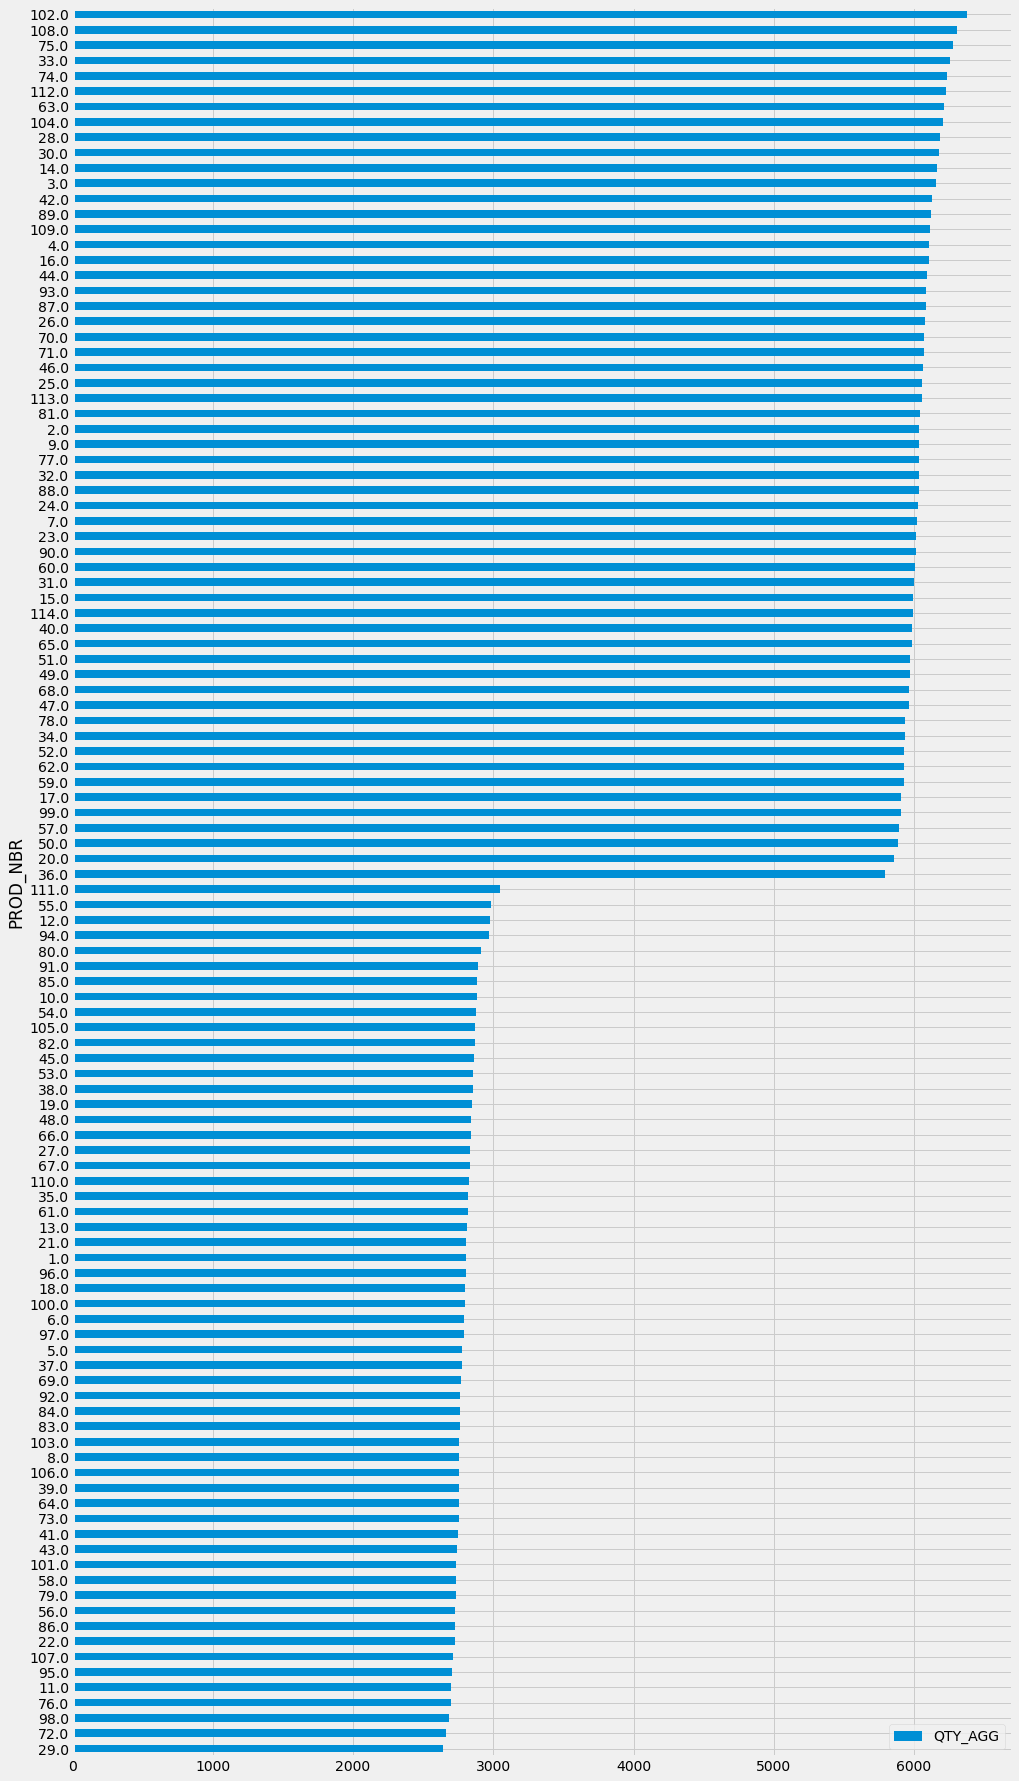

In [6]:
popularity = data[["PROD_NBR", "PROD_QTY"]].groupby(by="PROD_NBR",sort=False, as_index=False).sum()
popularity["QTY_AGG"] = popularity["PROD_QTY"]
popularity = popularity[["PROD_NBR", "QTY_AGG"]]
popularity.sort_values(by=["QTY_AGG"]).plot(kind="barh",y="QTY_AGG", x="PROD_NBR", figsize=(15,30))

In [7]:
popularity.describe()

PROD_NBR      QTY_AGG
count  114.000000   114.000000
mean    57.500000  4427.385965
std     33.052988  1636.621934
min      1.000000  2643.000000
25%     29.250000  2794.000000
50%     57.500000  4418.500000
75%     85.750000  6037.000000
max    114.000000  6381.000000

We can see a clear difference between very popular product (>5K) and others : we can divide products in 2 regarding this parameter

In [8]:
data = data.merge(popularity, on="PROD_NBR", how="left" )

In [9]:
data.loc[data["QTY_AGG"]<4000,"QTY_AGG"] = 0
data.loc[data["QTY_AGG"]>4000,"QTY_AGG"] = 1

#### b. Price clustering

<AxesSubplot:ylabel='PROD_NBR'>

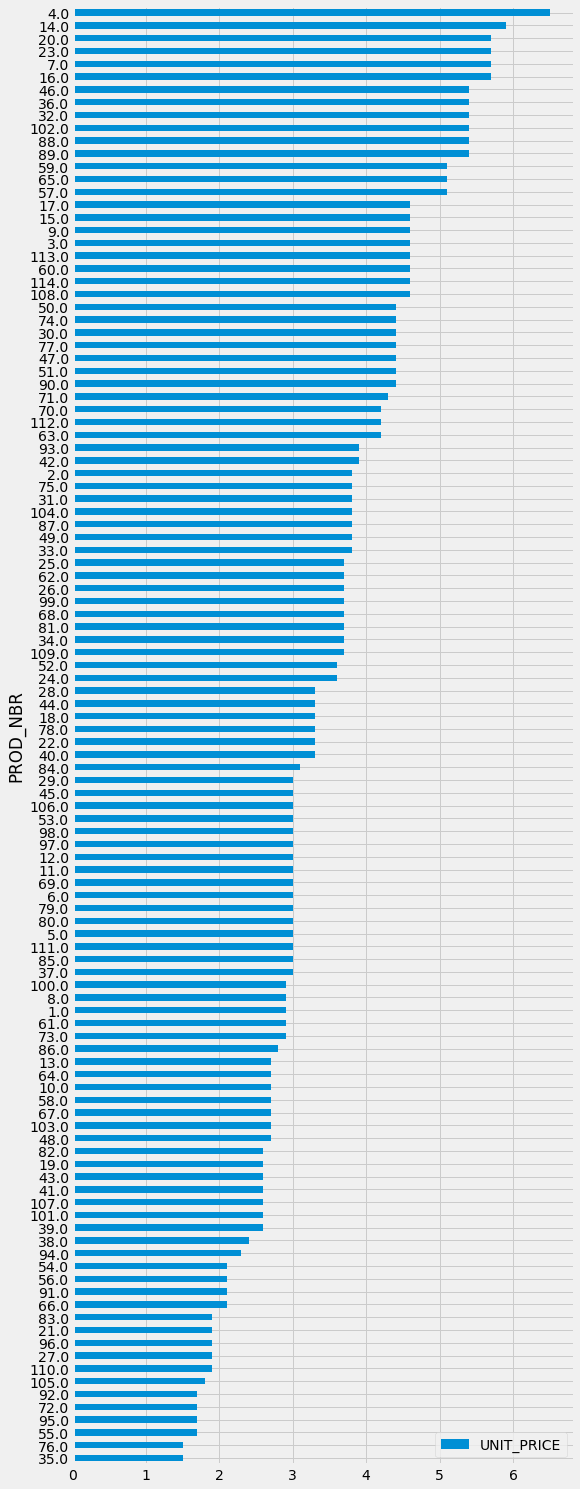

In [10]:
unit_prices = data[["PROD_NBR", "UNIT_PRICE"]].groupby(by="PROD_NBR",as_index=False).mean()
unit_prices["UNIT_PRICE"] = round(unit_prices["UNIT_PRICE"], 2)
unit_prices.sort_values(by="UNIT_PRICE", inplace=True)
unit_prices.plot(kind="barh", x="PROD_NBR", figsize=(8,25))

##### Kmeans

In [11]:
kmean = KMeans(n_clusters=5, random_state=0).fit(np.array(unit_prices["UNIT_PRICE"]).reshape(-1,1))
kmean.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

##### Mean_shift

In [12]:
mean_shift = MeanShift(bandwidth=0.4).fit(np.array(unit_prices["UNIT_PRICE"]).reshape(-1,1))
mean_shift.labels_

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6])

##### Dbscan

In [13]:
dbscan = DBSCAN(eps=0.2).fit(np.array(unit_prices["UNIT_PRICE"]).reshape(-1,1))
dbscan.labels_ + 1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 6, 6, 6, 6, 6, 6, 0, 0,
       0, 0, 0, 0])

<AxesSubplot:ylabel='PROD_NBR'>

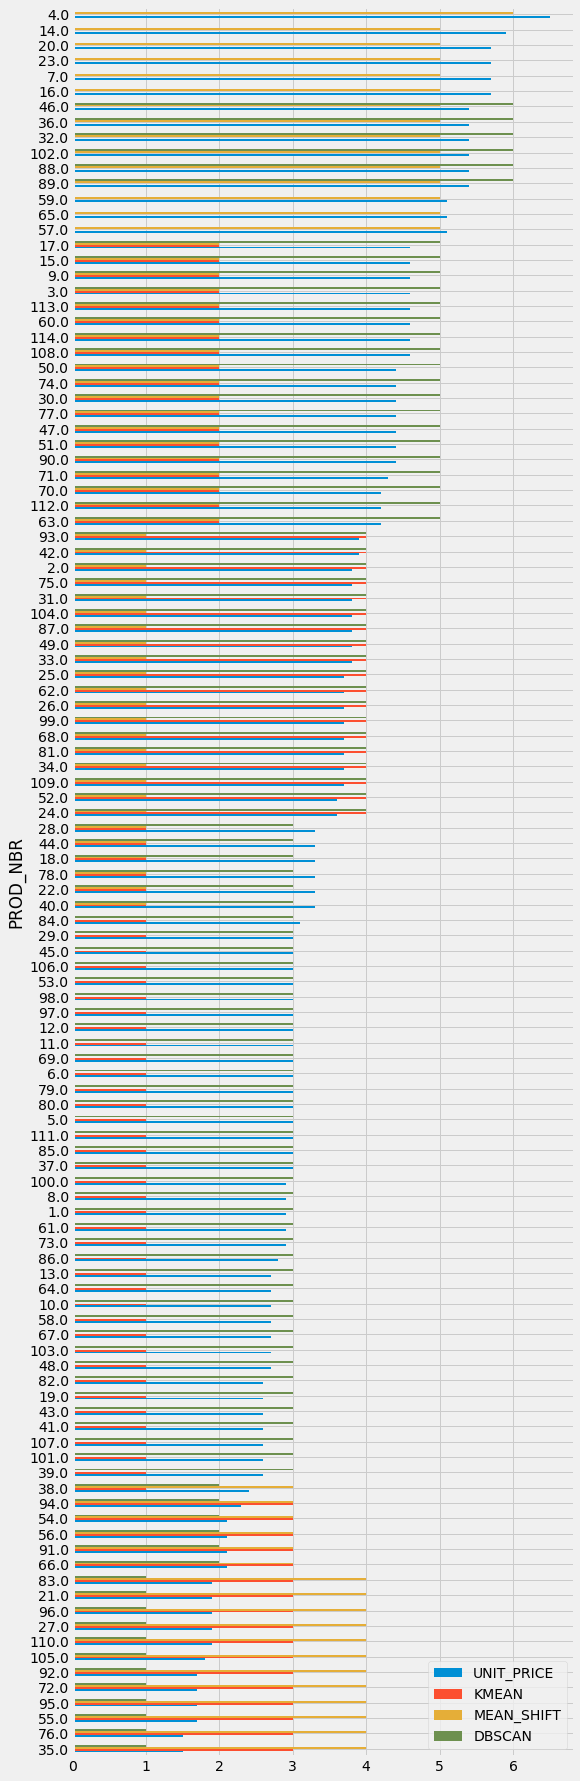

In [14]:
unit_prices["KMEAN"]=kmean.labels_
unit_prices["MEAN_SHIFT"]=mean_shift.labels_
unit_prices["DBSCAN"]=dbscan.labels_ + 1
unit_prices.plot(kind="barh", x="PROD_NBR", figsize=(8,30))

We will finally take Meanshift clusters, they seems to be more realistic

In [15]:
data = data.merge(unit_prices[["PROD_NBR","MEAN_SHIFT"]], on="PROD_NBR", how="left" )

#### c. Customer frequency

Let's count the frequency of attendance of customer

In [16]:
frequency = data[["LYLTY_CARD_NBR", "DATE"]].groupby(by="LYLTY_CARD_NBR", sort=False, as_index=False).nunique()

In [17]:
frequency.columns=["LYLTY_CARD_NBR", "FREQ"]

In [18]:
def freq(x):
    y = 0
    if (x + 1) // 4 < 1: # if I came to the store less than 4 times during the year I belong to group 1
        y = 0
    elif (x + 1) // 4 < 2:
        y = 1
    elif (x + 1) // 4  < 3:
        y = 2
    elif (x + 1) // 4 < 4:
        y = 3
    else:
        y = 4
    return y
        

In [19]:
frequency["FREQ_GROUP"] = frequency["FREQ"]
frequency["FREQ_GROUP"] = frequency["FREQ_GROUP"].apply(lambda x: freq(x))

In [20]:
frequency.head()

LYLTY_CARD_NBR  FREQ  FREQ_GROUP
0            1000     1           0
1            1002     1           0
2            1003     2           0
3            1004     1           0
4            1005     1           0

Distribution des quantités d'achat

In [21]:
data = data.merge(frequency[["LYLTY_CARD_NBR","FREQ_GROUP"]], on="LYLTY_CARD_NBR", how="left" )

In [22]:
data.head()

LYLTY_CARD_NBR              LIFESTAGE PREMIUM_CUSTOMER     DATE  STORE_NBR  \
0            1000  YOUNG SINGLES/COUPLES          Premium  43390.0        1.0   
1            1002  YOUNG SINGLES/COUPLES       Mainstream  43359.0        1.0   
2            1003         YOUNG FAMILIES           Budget  43531.0        1.0   
3            1003         YOUNG FAMILIES           Budget  43532.0        1.0   
4            1004  OLDER SINGLES/COUPLES       Mainstream  43406.0        1.0   

   PROD_NBR  PROD_QTY  UNIT_PRICE  QTY_AGG  MEAN_SHIFT  FREQ_GROUP  
0       5.0       2.0         3.0      0.0         0.0           0  
1      58.0       1.0         2.7      0.0         0.0           0  
2      52.0       1.0         3.6      1.0         1.0           0  
3     106.0       1.0         3.0      0.0         0.0           0  
4      96.0       1.0         1.9      0.0         4.0           0

#### c. Customer interbuy time score

Here we will create a new feature that will quantify the customer proximity to our store (how much time do they spend without buying).

In [23]:
def intertime(x):
    x = np.sort(x)    
    if x.size > 1:
        temp = np.mean(x[1:] - x[:-1])
        return temp if temp != 0 else 365        
    else:
        return 365

In [24]:
interbuy_time = round(data.groupby("LYLTY_CARD_NBR").agg(interbuy=("DATE",intertime)), 1)

<AxesSubplot:ylabel='Frequency'>

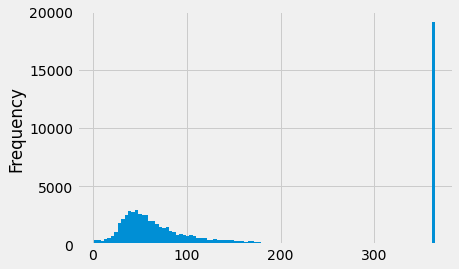

In [25]:
interbuy_time["interbuy"].plot(kind="hist", bins=100)

In [26]:
interbuy_time["interbuy"].value_counts().sort_index()

1.0         80
1.5          1
2.0         63
2.3          1
2.5          4
         ...  
357.0        1
358.0        1
359.0        1
360.0        4
365.0    19106
Name: interbuy, Length: 1123, dtype: int64

In [27]:
def intertime_group(x):
    y = 0
    if x <= 7: # if I came to the store less than 4 times during the year I belong to group 1
        y = 0
    elif x <= 14:
        y = 1
    elif x <= 31:
        y = 2
    elif x <= 93:
        y = 3
    else:
        y = 4
    return y

In [28]:
interbuy_time["intertime_group"] = interbuy_time["interbuy"]
interbuy_time["intertime_group"] = interbuy_time["intertime_group"].apply(lambda x: intertime_group(x))

# III. Segmentation

## A.Segmentation without grouping features

In [29]:
# total buy for each customer
total_purchases = pd.DataFrame({"TOTAL":data["PROD_QTY"] * data["UNIT_PRICE"], "LYLTY_CARD_NBR" : data["LYLTY_CARD_NBR"]})
total_purchases = total_purchases.groupby(by="LYLTY_CARD_NBR", as_index=False).sum()

In [42]:
dummies1 = pd.get_dummies(customer["LIFESTAGE"])
dummies2 = pd.get_dummies(customer["PREMIUM_CUSTOMER"])

In [43]:
for_clustering = pd.DataFrame({"mean_basket_price":(total_purchases["TOTAL"] / frequency["FREQ"])})
for_clustering.loc[for_clustering["mean_basket_price"].isnull(),"mean_basket_price"] = 0
for_clustering["freq"] = frequency["FREQ"]
for_clustering["interbuy_time"] = list(interbuy_time["interbuy"])
for_clustering[["mean_basket_price", "freq", "interbuy_time"]] = StandardScaler(copy=False).fit_transform(for_clustering)
for_clustering[dummies1.columns] = dummies1
for_clustering[dummies2.columns] = dummies2

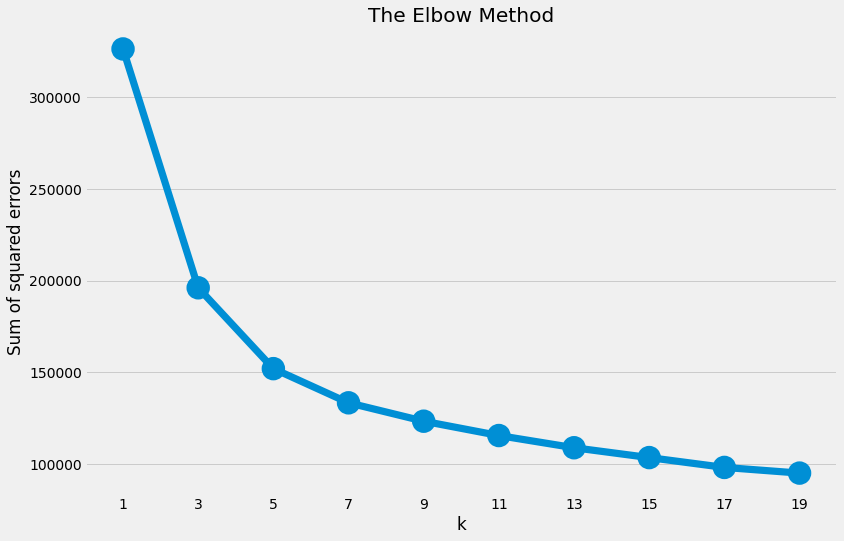

In [178]:

sse = {}
kmeans = []
# Fit KMeans and calculate SSE for each k
for k in tqdm(range(1, 21, 2)):
  
    # Initialize KMeans with k clusters
    kmeans.append(KMeans(n_clusters=k, random_state=1))
    
    # Fit KMeans on the normalized dataset
    kmeans[(k-1)//2].fit(for_clustering)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans[(k-1)//2].inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### 1. Choice of the number of clusters

We will choose the number of clusters between 5 and 15

#### a. Total of sales variation

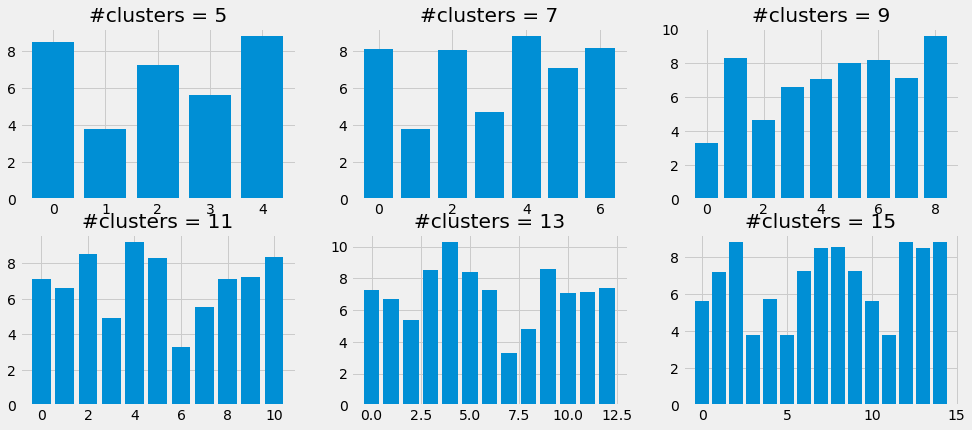

In [208]:
k_sales_var =[]
plt.figure(figsize=(15,10))
for i in range(5,16,2):
    labels = kmeans[(i-1)//2].labels_
    k_sales_var.append([])
    for j in range(i):
        k_sales_var[(i-5)//2].append(for_clustering2[labels== j]["mean_basket_price"].median())
    plt.subplot(3,3,(i-3)//2)
    plt.bar(np.arange(0, i), k_sales_var[(i-5)//2])
    plt.title(f"#clusters = {i}")

### b. Premium classes distribution per cluster

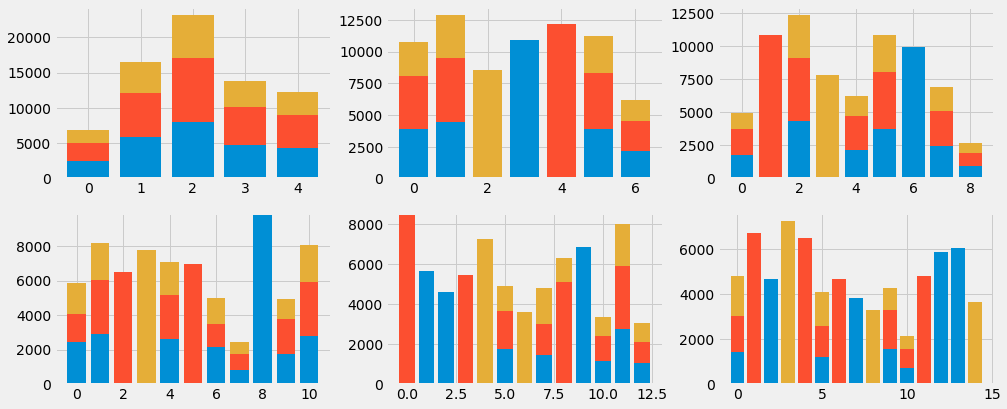

In [159]:
k_prem_var =[]
plt.figure(figsize=(15,10))
for i in range(5,16,2):
    ind = (i-5)//2
    labels = kmeans[(i-1)//2].labels_
    k_prem_var.append(np.empty((i,3)))
    for j in range(i):
        k_prem_var[ind][j,:]=[for_clustering[labels== j][0].sum(),
                                for_clustering[labels== j][1].sum(),
                                for_clustering[labels== j][2].sum()]
    plt.subplot(3,3,ind+1)
    plt.bar(np.arange(0,i), k_prem_var[ind][:,0])
    plt.bar(np.arange(0,i), k_prem_var[ind][:,1], bottom=k_prem_var[ind][:,0])
    plt.bar(np.arange(0,i), k_prem_var[ind][:,2], bottom=k_prem_var[ind][:,0] + k_prem_var[ind][:,1] )

### c. frequency distribution

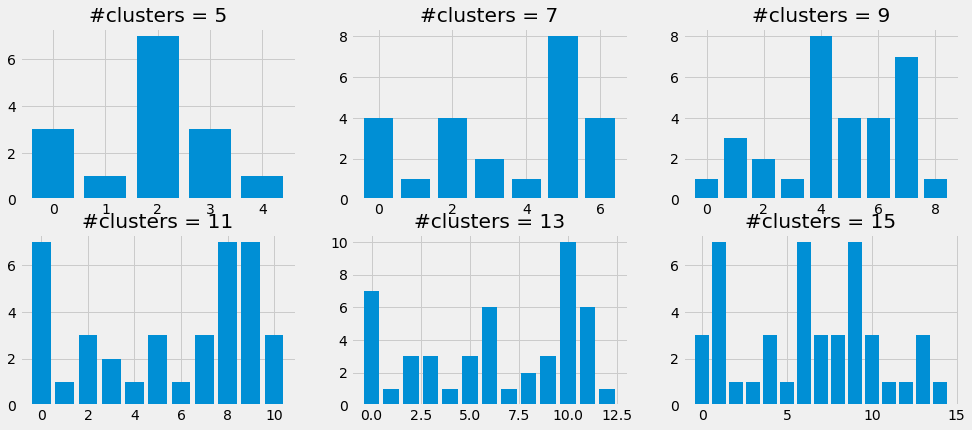

In [207]:
k_freq_var =[]
plt.figure(figsize=(15,10))
for i in range(5,16,2):
    labels = kmeans[(i-1)//2].labels_
    k_freq_var.append([])
    for j in range(i):
        k_freq_var[(i-5)//2].append(for_clustering2[labels== j]["freq"].median())
    plt.subplot(3,3,(i-3)//2)
    plt.bar(np.arange(0, i), k_freq_var[(i-5)//2])
    plt.title(f"#clusters = {i}")

### d. life stage group

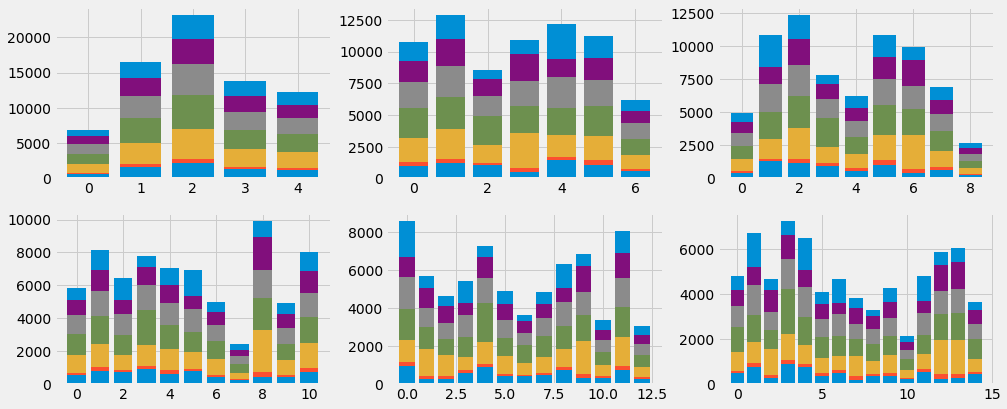

In [162]:
k_lifestage_var =[]
lifestage_dic = {1:"MIDAGE SINGLES/COUPLES",
                 2:"NEW FAMILIES",
                 3:"OLDER FAMILIES",
                 4:"OLDER SINGLES/COUPLES",
                 5:"RETIREES",
                 6:"YOUNG FAMILIES",
                 7:"YOUNG SINGLES/COUPLES"
}


    
plt.figure(figsize=(15,10))
for i in range(5,16,2):
    labels = kmeans[(i-1)//2].labels_
    k_lifestage_var.append(np.empty((i,7)))
    for j in range(i):
        for k in range(7):
            k_lifestage_var[(i-5)//2][j,k]=for_clustering[labels== j][lifestage_dic[k+1]].sum()
    plt.subplot(3,3,(i-3)//2)
    bottom = 0
    for k in range(7):
        plt.bar(np.arange(0,i), k_lifestage_var[(i-5)//2][:,k], bottom=bottom)
        bottom += k_lifestage_var[(i-5)//2][:,k]

### e. Interbuy time

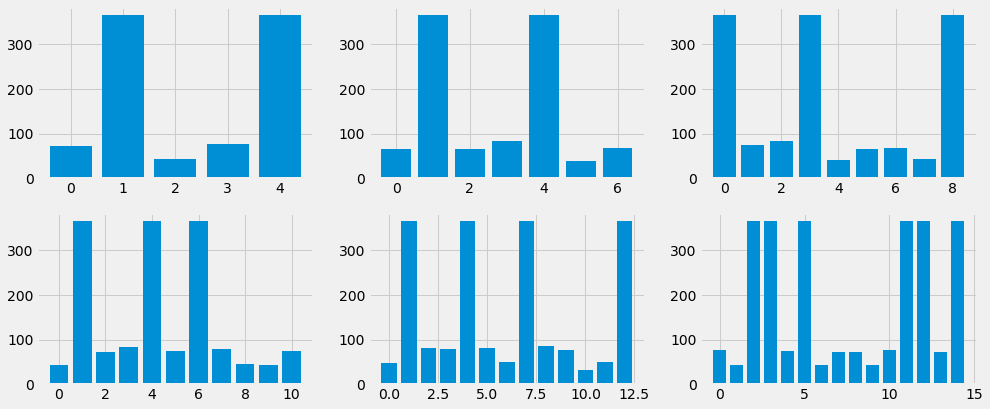

In [206]:
k_interbuy_var =[]

plt.figure(figsize=(15,10))
for i in range(5,16,2):
    labels = kmeans[(i-1)//2].labels_
    k_interbuy_var.append([])
    for j in range(i):
        k_interbuy_var[(i-5)//2].append(interbuy_time[labels== j]["interbuy"].median())
    plt.subplot(3,3,(i-3)//2)
    plt.bar(np.arange(0,i), k_interbuy_var[(i-5)//2])

## B. Segmentation with grouping features

In [32]:
kmean_basket_value = KMeans(n_clusters=5, random_state=0).fit(np.array(for_clustering["mean_basket_price"]).reshape(-1,1))

In [33]:
#for_clustering2 = pd.DataFrame({"mean_basket_price":(total_purchases["TOTAL"] / frequency["FREQ"])})
#for_clustering2.loc[for_clustering2["mean_basket_price"].isnull(),"mean_basket_price"] = 0
for_clustering2 = pd.DataFrame({'mean_basket_price':kmean_basket_value.labels_})
for_clustering2["freq"] = frequency["FREQ_GROUP"]
for_clustering2["interbuy_time"] = list(interbuy_time["intertime_group"])
for_clustering2[dummies1.columns] = dummies1
for_clustering2[dummies2.columns] = dummies2

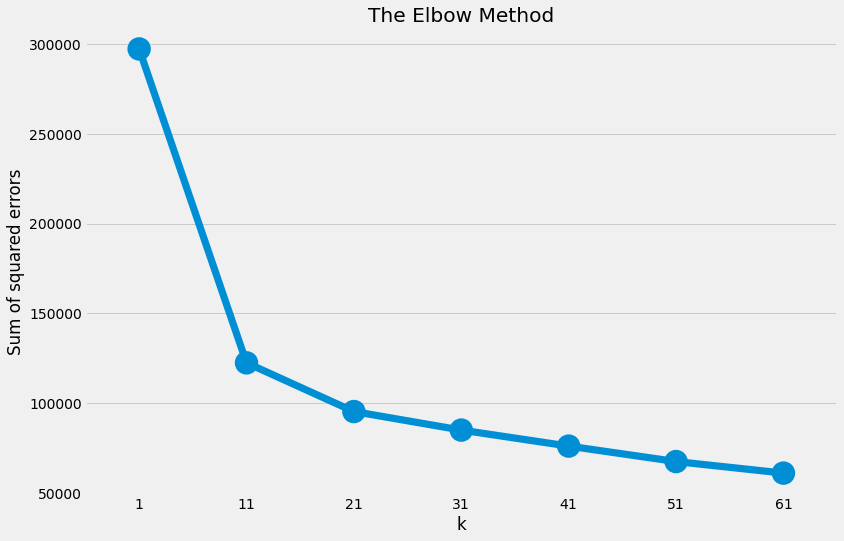

In [47]:
sse = {}
kmeans2 = []
# Fit KMeans and calculate SSE for each k
for k in tqdm(range(1, 70, 10)):
  
    # Initialize KMeans with k clusters
    kmeans2.append(KMeans(n_clusters=k, random_state=1))
    
    # Fit KMeans on the normalized dataset
    kmeans2[(k-1)//10].fit(for_clustering2)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans2[(k-1)//10].inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### a. Purchases

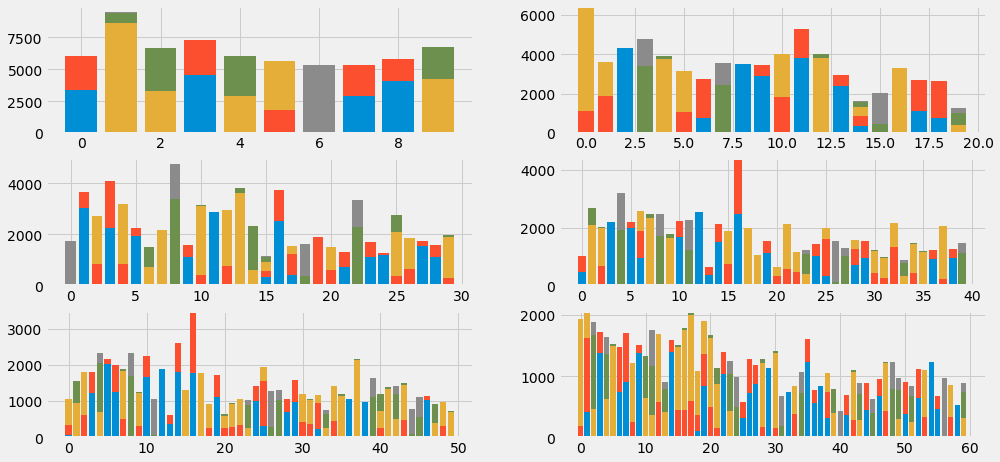

In [48]:
k_purchases2_var = []
plt.figure(figsize=(15,10))
for i in range(10,70,10):
    labels = kmeans2[i//10].labels_
    k_purchases2_var.append(np.empty((i,5)))
    for j in range(i):
        for k in range(5):
            k_purchases2_var[(i-10)//10][j,k] = sum(for_clustering2[labels== j]["mean_basket_price"]==k)
    plt.subplot(4,2,i//10)
    bottom = 0
    for k in range(5):
        plt.bar(np.arange(0,i), k_purchases2_var[(i-10)//10][:,k], bottom=bottom)
        
        bottom += k_purchases2_var[(i-10)//10][:,k]

### b.Frequency

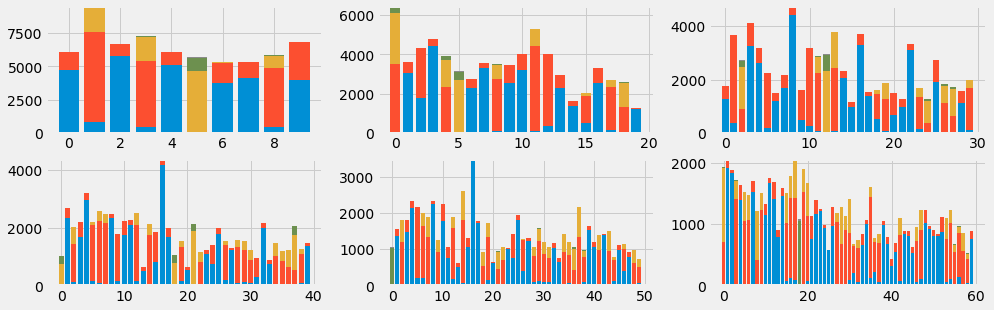

In [52]:
k_freq_var = []
plt.figure(figsize=(15,10))
for i in range(10,70,10):
    labels = kmeans2[(i)//10].labels_
    k_freq_var.append(np.empty((i,5)))
    for j in range(i):
        for k in range(5):
            k_freq_var[(i-10)//10][j,k] = sum(for_clustering2[labels== j]["freq"]==k)
    plt.subplot(4,3,(i)//10)
    bottom = 0
    for k in range(5):
        plt.bar(np.arange(0,i), k_freq_var[(i-10)//10][:,k], bottom=bottom)
        
        bottom += k_freq_var[(i-10)//10][:,k]

### c.interbuy time

IndexError: list index out of range

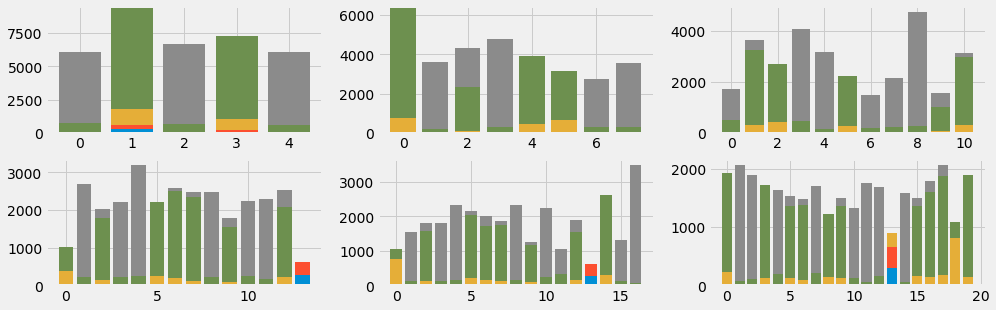

In [50]:
k_ibtime_var = []
plt.figure(figsize=(15,10))
for i in range(5,36,3):
    labels = kmeans2[(i-2)//3].labels_
    k_ibtime_var.append(np.empty((i,5)))
    for j in range(i):
        for k in range(5):
            k_ibtime_var[(i-5)//3][j,k] = sum(for_clustering2[labels== j]["interbuy_time"]==k)
    plt.subplot(4,3,(i-2)//3)
    bottom = 0
    for k in range(5):
        plt.bar(np.arange(0,i), k_ibtime_var[(i-5)//3][:,k], bottom=bottom)
        bottom += k_ibtime_var[(i-5)//3][:,k]

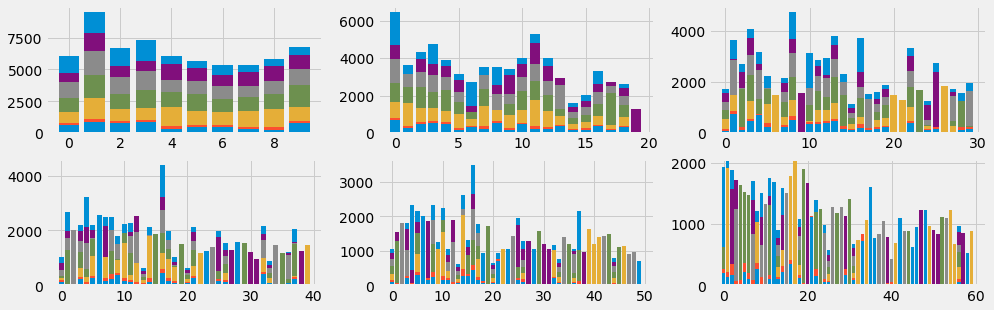

In [53]:
k_lifestage2_var =[]
lifestage_dic = {4:"MIDAGE SINGLES/COUPLES",
                 2:"NEW FAMILIES",
                 5:"OLDER FAMILIES",
                 6:"OLDER SINGLES/COUPLES",
                 7:"RETIREES",
                 3:"YOUNG FAMILIES",
                 1:"YOUNG SINGLES/COUPLES"
}
plt.figure(figsize=(15,10))
for i in range(10,70,10):
    labels = kmeans2[(i)//10].labels_
    k_lifestage2_var.append(np.empty((i,7)))
    for j in range(i):
        for k in range(7):
            k_lifestage2_var[(i-10)//10][j,k] = for_clustering2[labels== j][lifestage_dic[k+1]].sum()
    plt.subplot(4,3,(i)//10)
    bottom = 0
    for k in range(7):
        plt.bar(np.arange(0,i), k_lifestage2_var[(i-10)//10][:,k], bottom=bottom)
        bottom += k_lifestage2_var[(i-10)//10][:,k]

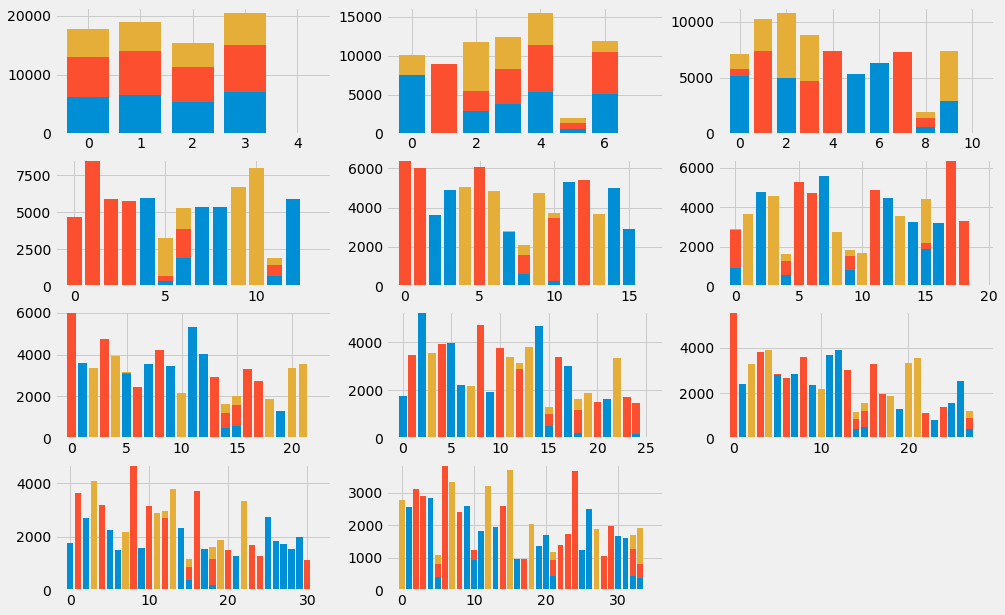

In [46]:
k_premgroup2_var =[]
premium_dic = {1:"Budget",
               2:'Mainstream',
               3:"Premium"
}
plt.figure(figsize=(15,10))
for i in range(5,36,3):
    labels = kmeans2[(i-1)//3].labels_
    k_premgroup2_var.append(np.empty((i,3)))
    for j in range(i):
        for k in range(3):
            k_premgroup2_var[(i-5)//3][j,k] = for_clustering2[labels== j][premium_dic[k+1]].sum()
    plt.subplot(4,3,(i-2)//3)
    bottom = 0
    for k in range(3):
        plt.bar(np.arange(0,i), k_premgroup2_var[(i-5)//3][:,k], bottom=bottom)
        bottom += k_premgroup2_var[(i-5)//3][:,k]

## C.Alldummies

In [34]:
basket_price_dummies = pd.get_dummies(pd.DataFrame({'mean_basket_price':kmean_basket_value.labels_}))
fred_dummies = pd.get_dummies(frequency["FREQ_GROUP"])
intertime_buyudummies = pd.get_dummies(list(interbuy_time["intertime_group"]))

In [37]:
for_clustering3 = basket_price_dummies
for_clustering3[fred_dummies.columns] = fred_dummies
for_clustering3[intertime_buyudummies.columns] = intertime_buyudummies
for_clustering3[dummies1.columns] = dummies1
for_clustering3[dummies2.columns] = dummies2

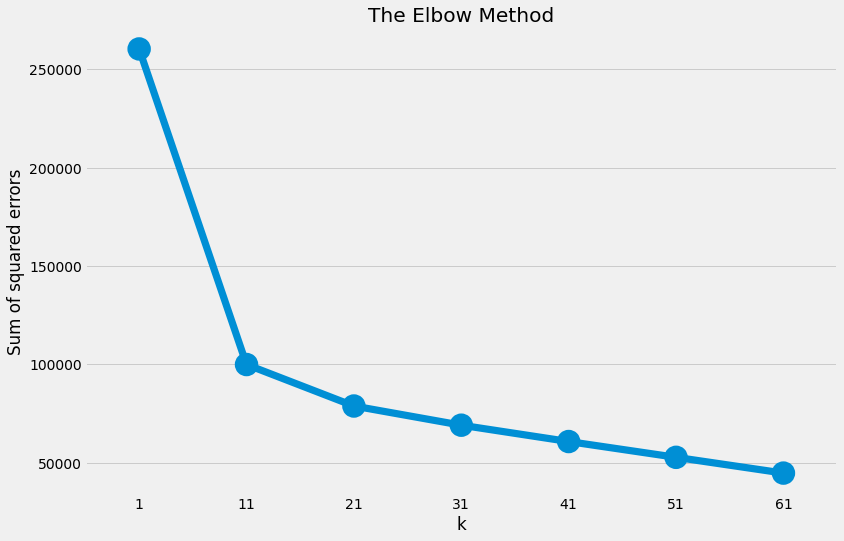

In [39]:
sse = {}
kmeans3 = []
# Fit KMeans and calculate SSE for each k
for k in tqdm(range(1, 70, 10)):
  
    # Initialize KMeans with k clusters
    kmeans3.append(KMeans(n_clusters=k, random_state=1))
    
    # Fit KMeans on the normalized dataset
    kmeans3[(k-1)//10].fit(for_clustering2)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans3[(k-1)//10].inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## D.categorical encoding + normal

In [47]:
lifestage_dic = {"MIDAGE SINGLES/COUPLES":4,
                 "NEW FAMILIES":2,
                 "OLDER FAMILIES":5,
                 "OLDER SINGLES/COUPLES":6,
                 "RETIREES":7,
                 "YOUNG FAMILIES":3,
                 "YOUNG SINGLES/COUPLES":1
}
premium_dic = {"Premium":3,
                 "Mainstream":2,
                 "Budget":1
}

In [48]:
for_clustering4 = pd.DataFrame({"mean_basket_price":(total_purchases["TOTAL"] / frequency["FREQ"])})
for_clustering4.loc[for_clustering["mean_basket_price"].isnull(),"mean_basket_price"] = 0
for_clustering4["freq"] = frequency["FREQ"]
for_clustering4["interbuy_time"] = list(interbuy_time["interbuy"])
for_clustering4["LifeStage"] = customer["LIFESTAGE"].apply(lambda x:lifestage_dic[x] )
for_clustering4["Premium_customer"] = customer["PREMIUM_CUSTOMER"].apply(lambda x:premium_dic[x] )
#for_clustering[["mean_basket_price", "freq", "interbuy_time"]] = StandardScaler(copy=False).fit_transform(for_clustering)


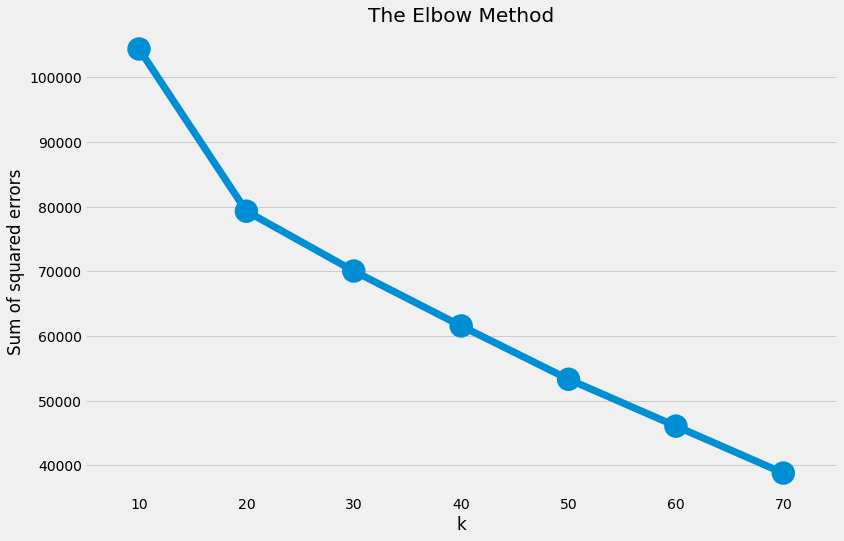

In [50]:
sse = {}
kmeans4 = []
# Fit KMeans and calculate SSE for each k
for k in tqdm(range(10, 71, 10)):
  
    # Initialize KMeans with k clusters
    kmeans4.append(KMeans(n_clusters=k, random_state=1))
    
    # Fit KMeans on the normalized dataset
    kmeans4[(k-1)//10].fit(for_clustering2)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans4[(k-1)//10].inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### a. Purchases

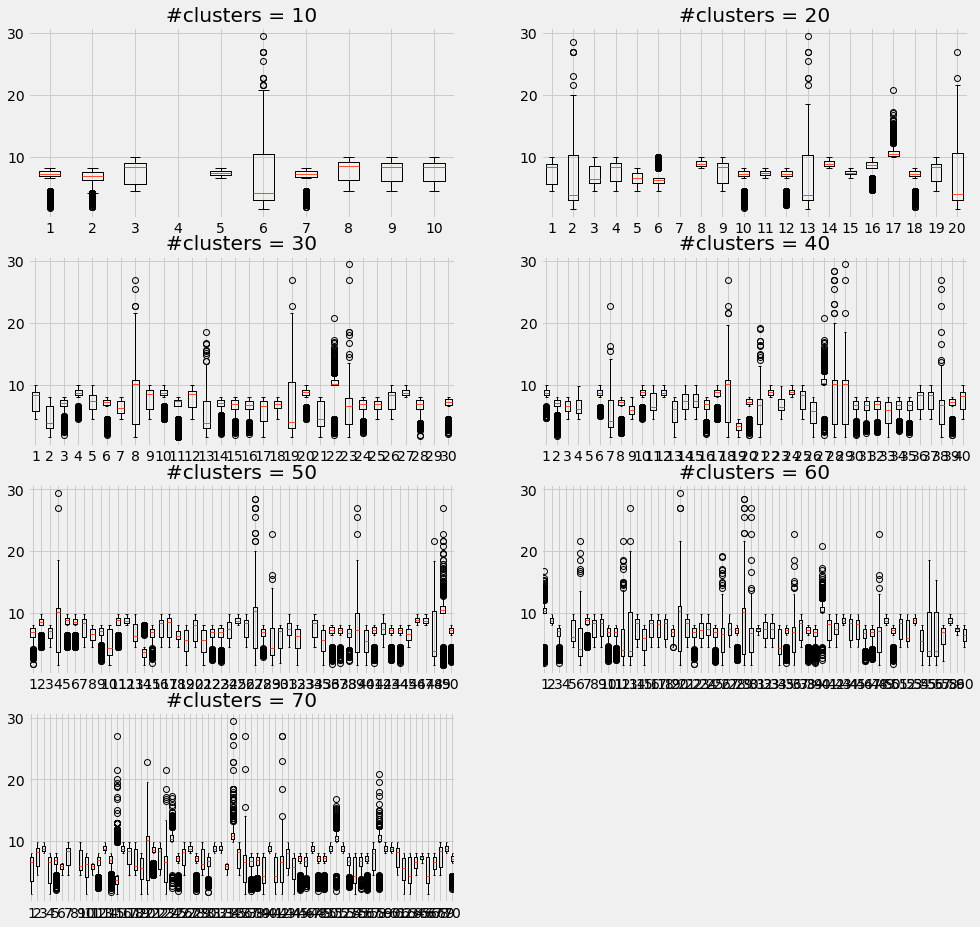

In [63]:
k_purchases4_var = []
plt.figure(figsize=(15,15))
for i in range(10,71,10):
    labels = kmeans4[(i-10)//10].labels_
    k_purchases4_var.append([])
    for j in range(i):
        k_purchases4_var[(i-10)//10].append(for_clustering4[labels== j]["mean_basket_price"])
    plt.subplot(4,2,(i)//10)
    plt.boxplot(k_purchases4_var[(i-10)//10])
    plt.title(f"#clusters = {i}")

In [56]:
np.arange(10,71,10)

array([10, 20, 30, 40, 50, 60, 70])

In [58]:
k_purchases4_var

[[7.236363636363636,
  6.880000000000001,
  8.3,
  3.95,
  7.4,
  4.1,
  7.2,
  8.514285714285714,
  8.32,
  8.275000000000002]]


Commencer par un cohort analysis sur la retention, la valeur monétaire moyenne, dépense par chips , la fréquence autre metrique? moyenne sur les 7 * 3 categories 
Faire un score RFM et observer le score moyen de chaque catégorie.
Remettre les stores en tant que features, ils apportent une information géographique (pour le clustering). 
Pas besoin de beaucoup de clusters, des qu'on atteint la concavité on est bon.
etudier l'utilité de la taille des paquets de ships (dans le nom) et autres informations